## PhaseNO for multi-station earthquake detection and phase picking
### plot results

In [1]:
import os
import obspy
import numpy as np
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
def _detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False):

    """
    
    Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
        
    mph : {None, number}, default=None
        detect peaks that are greater than minimum peak height.
        
    mpd : int, default=1
        detect peaks that are at least separated by minimum peak distance (in number of data).
        
    threshold : int, default=0
        detect peaks (valleys) that are greater (smaller) than `threshold in relation to their immediate neighbors.
        
    edge : str, default=rising
        for a flat peak, keep only the rising edge ('rising'), only the falling edge ('falling'), both edges ('both'), or don't detect a flat peak (None).
        
    kpsh : bool, default=False
        keep peaks with same height even if they are closer than `mpd`.
        
    valley : bool, default=False
        if True (1), detect valleys (local minima) instead of peaks.

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Modified from 
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    

    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    return ind, x[ind]

In [3]:
Data_Path  = './example/waveforms'
probfolder = './example/results2/probability/'

stations_new = pd.read_csv('./example/stations.csv',sep=',')
stations_new["st_id"]  = stations_new["id"].apply(lambda x: x.split('.')[0]+'.'+x.split('.')[1]+'.'+x.split('.')[-1])

center = (-117.6, 35.8)
x_min, y_min = center[0] - 1, center[1] - 1

timestamp = datetime(2019, 7, 6, 8, 0)
itime = timestamp.strftime("%Y-%m-%dT%H:%M")
print('current at', itime)

PLOT = 1

current at 2019-07-06T08:00


## prepare station list

number of stations at  2019-07-06T08:00 :  36


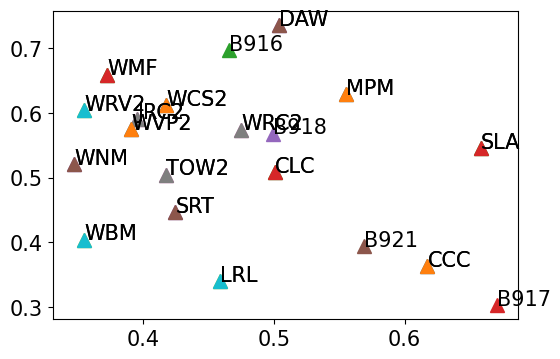

In [4]:
station_all = []
for fname in os.listdir(Data_Path):    # The list is in arbitrary order
    if itime in fname:   
        channel_name = fname.split('.')[2]
        station_name = fname.split('.')[1]
        network_name = fname.split('.')[0]

        station_all.append(network_name+'.'+station_name+'.'+channel_name)

print('number of stations at ', itime, ': ', len(station_all))

if PLOT == 1:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for i,staname in enumerate(station_all):
        sta = staname.split('.')[1]
        x = (stations_new.loc[stations_new['station'] == sta].iloc[0]['longitude']- x_min)/2
        y = (stations_new.loc[stations_new['station'] == sta].iloc[0]['latitude']- y_min)/2
        ax.plot(x,y,'^',markersize=10)
        ax.text(x,y,sta)
    ax.locator_params(axis='both', nbins=5)

networks = []
stations = []
channels = []
dis = []
ids = []
for sta in station_all:

    ch = sta.split('.')[-1]
    st = sta.split('.')[1]
    ne = sta.split('.')[0]
    channels.append(ch)
    stations.append(st)
    networks.append(ne)
    temp = stations_new.loc[stations_new['station'] == st]
    sta_select = temp.loc[temp['channel'] == ch]
    ids.append(sta_select.iloc[0]['st_id'])

    x = (stations_new.loc[stations_new['station'] == st].iloc[0]['longitude']- x_min)/2
    y = (stations_new.loc[stations_new['station'] == st].iloc[0]['latitude'] - y_min)/2
    dis.append(np.sqrt((x-0.5)**2+(y-0.5)**2))

d = {'id': ids,
        'network': networks, 
        'station': stations, 
        'channel': channels,
        'distance': dis}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['distance'], ignore_index=True)

num_station = len(stations)

## read waveforms (mseed)

In [5]:
fname = []
bg_st=obspy.core.Stream()
temp = []
highpass_filter = 1
for net,sta,cha in tqdm(zip(df['network'],df['station'],df['channel'])): 
    
    fname.append(net+'.'+sta+'.'+cha+'.'+itime+'.mseed')
    mseed = obspy.read(os.path.join(Data_Path,net+'.'+sta+'.'+cha+'.'+itime+'.mseed'))
    mseed = mseed.detrend("spline", order=2, dspline=5 * mseed[0].stats.sampling_rate)
    mseed = mseed.merge(fill_value=0)
    if highpass_filter > 0:
        mseed = mseed.filter("highpass", freq=highpass_filter)
    if len(mseed) < 3:
        for r in np.arange(3-len(mseed)):
            mseed.append(mseed[0])

    bg_st += mseed[:3]

starttime = min([st.stats.starttime for st in bg_st])
endtime = max([st.stats.endtime for st in bg_st])
bg_st = bg_st.trim(starttime, endtime, pad=True, fill_value=0)
temp = np.array(bg_st)

split_points=list(range(3,len(bg_st),3))
waveforms  = np.split(temp[:,:360000],split_points)

0it [00:00, ?it/s]

36it [00:12,  2.86it/s]


## read predicted probabilities and detect peaks

In [6]:
sample_rate = 100
threshold = 0.3

p_pro_time_stream =obspy.core.Stream()
s_pro_time_stream =obspy.core.Stream()

p_idx, p_prob, s_idx, s_prob = [], [], [], []

for net,sta,cha in tqdm(zip(df['network'],df['station'],df['channel'])): 
    id = net+'.'+sta+'.'+cha+'.'+itime+'.mseed'
    st = obspy.read(probfolder+id)

    p_pro_time_stream += st[0]
    s_pro_time_stream += st[1]

    P_seq, S_seq = np.array(st[0]), np.array(st[1])
    p, p_pro =_detect_peaks(P_seq, mph=threshold, mpd=1.0*sample_rate)
    s, s_pro =_detect_peaks(S_seq, mph=threshold, mpd=1.0*sample_rate)

    p_idx.append(p)
    p_prob.append(p_pro)
    s_idx.append(s)
    s_prob.append(s_pro)

temp = np.array(p_pro_time_stream)
split_points=list(range(1,len(p_pro_time_stream),1))
p_pro_time = np.split(temp[:,:360000],split_points)
temp = np.array(s_pro_time_stream)
split_points=list(range(1,len(s_pro_time_stream),1))
s_pro_time = np.split(temp[:,:360000],split_points)

36it [00:10,  3.36it/s]


## plot one-minute waveforms and detections for all stations

([], [])

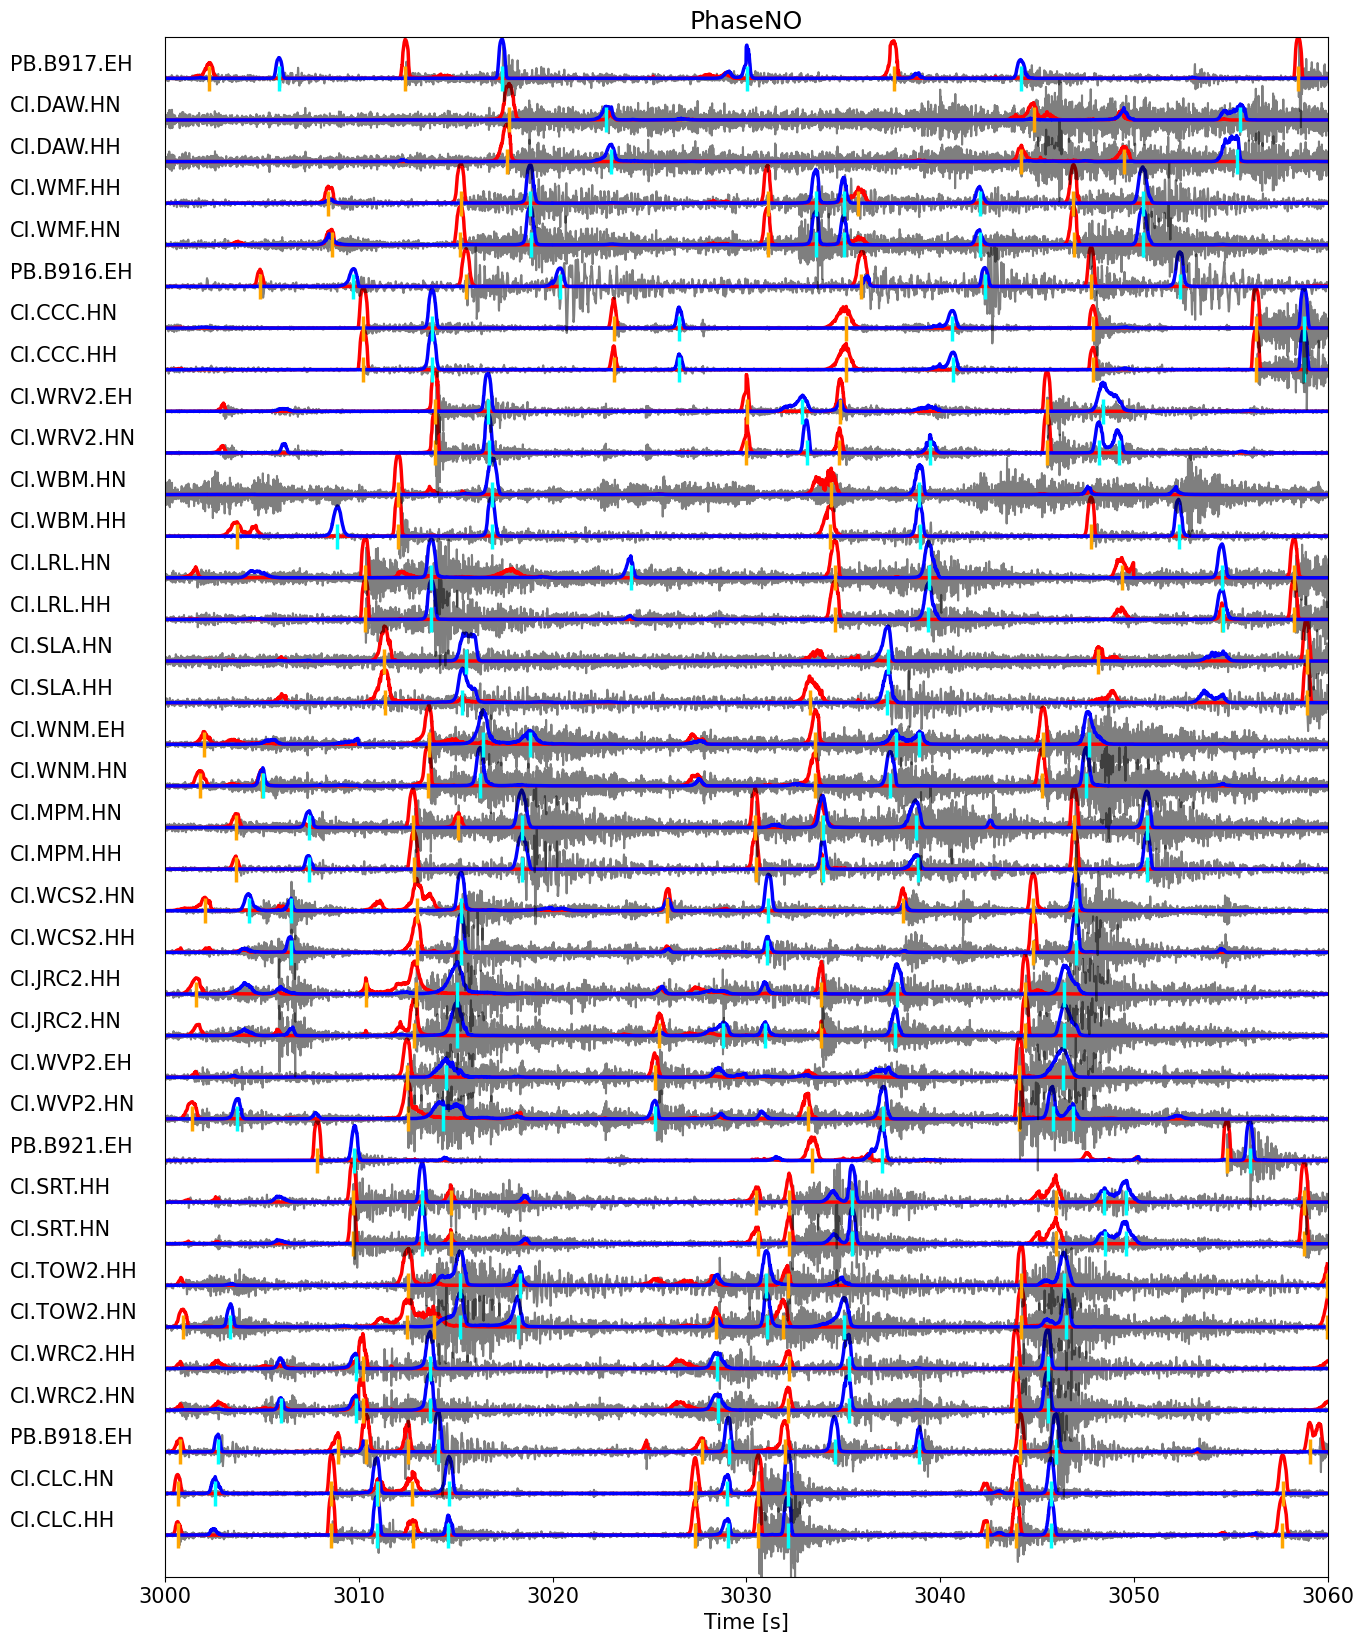

In [7]:
minute = 50; t0 = minute*60; t1 = t0+60

barlength=0.3
lw = 2.5
sampling_rate = 100
tt = np.arange(t0,t1,1/sampling_rate)

plt.figure(figsize=(15,20))
for ista in np.arange(num_station):
    waveform = waveforms[ista][2,t0*sampling_rate:t1*sampling_rate]
    p_prob_plot = p_pro_time[ista][0,t0*sampling_rate:t1*sampling_rate]
    s_prob_plot = s_pro_time[ista][0,t0*sampling_rate:t1*sampling_rate]
    plt.plot(tt,1*(waveform-waveform.mean())/waveform.max()+ista,'k',alpha=0.5)  
    plt.plot(tt,p_prob_plot+ista,'red',lw=lw, alpha=1)  
    plt.plot(tt,s_prob_plot+ista,'b',lw=lw, alpha=1)      
    plt.vlines(p_idx[ista]/100,ista-barlength,ista+barlength,'orange',lw=lw)
    plt.vlines(s_idx[ista]/100,ista-barlength,ista+barlength,'cyan',lw=lw)
    plt.text(t0-8,ista+0.2,df['id'][ista], color = 'k')

plt.xlabel('Time [s]')
plt.title('PhaseNO')
plt.xlim([t0,t1])
plt.ylim([-1,num_station])
plt.yticks([])

# plt.savefig('phaseno_wavefroms_itime_'+itime+'_min_'+str(minute)+'.png', bbox_inches="tight",transparent=True, dpi=300)